# Serie de tiempo del clima

# Instalación de librerías

# Preparación del ambiente

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd
from datetime import date

# Data visualization
import cufflinks as cf
import plotly.express as px

# Modeling
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Environment setup
cf.go_offline()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
from google.colab import auth
# from google.cloud import bigquery
import gspread
import re
from google.auth import default
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
creds, _ = default()
gc = gspread.authorize(creds)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga de datos y data Wrangling

In [6]:
import requests
import pandas as pd
import requests
import pandas as pd
from datetime import date

df_alcaldias = pd.DataFrame([
    ("ALVARO OBREGON", 19.361, -99.194),
    ("AZCAPOTZALCO", 19.485, -99.185),
    ("BENITO JUAREZ", 19.380, -99.161),
    ("COYOACAN", 19.343, -99.156),
    ("CUAJIMALPA", 19.355, -99.291),
    ("CUAUHTEMOC", 19.432, -99.133),
    ("GUSTAVO A MADERO", 19.485, -99.110),
    ("IZTACALCO", 19.395, -99.097),
    ("IZTAPALAPA", 19.346, -99.062),
    ("MAGDALENA CONTRERAS", 19.313, -99.241),
    ("MIGUEL HIDALGO", 19.434, -99.200),
    ("MILPA ALTA", 19.192, -99.023),
    ("TLAHUAC", 19.286, -99.041),
    ("TLALPAN", 19.287, -99.167),
    ("VENUSTIANO CARRANZA", 19.430, -99.098),
    ("XOCHIMILCO", 19.263, -99.104),
], columns=["alcaldia","lat","lon"])


def get_historic_climate(lat, lon, start, end):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": [
            "temperature_2m",
            "apparent_temperature",
            "precipitation",
            "precipitation_probability",
            "windspeed_10m",
            "relativehumidity_2m",
            "weathercode"
        ],
        "timezone": "America/Mexico_City"
    }
    r = requests.get(url, params=params)
    return pd.DataFrame(r.json()["hourly"])

def get_forecast_climate(lat, lon):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": [
            "temperature_2m",
            "apparent_temperature",
            "precipitation",
            "precipitation_probability",
            "windspeed_10m",
            "relativehumidity_2m",
            "weathercode"
        ],
        "timezone": "America/Mexico_City"
    }
    r = requests.get(url, params=params)
    return pd.DataFrame(r.json()["hourly"])

In [8]:
lat=19.361
lon=-99.194

df_hist = get_historic_climate(lat, lon, "2026-01-01", "2026-02-14")
df_fut  = get_forecast_climate(lat, lon)

df_clima = pd.concat([df_hist, df_fut], ignore_index=True)

In [9]:
df_clima['time']

,time
0,2026-01-01T00:00
1,2026-01-01T01:00
2,2026-01-01T02:00
3,2026-01-01T03:00
4,2026-01-01T04:00
...,...
1243,2026-02-22T19:00
1244,2026-02-22T20:00
1245,2026-02-22T21:00
1246,2026-02-22T22:00


In [10]:
df_alcaldias

,alcaldia,lat,lon
0,ALVARO OBREGON,19.36100,-99.19400
1,AZCAPOTZALCO,19.48500,-99.18500
2,BENITO JUAREZ,19.38000,-99.16100
3,COYOACAN,19.34300,-99.15600
4,CUAJIMALPA,19.35500,-99.29100
5,CUAUHTEMOC,19.43200,-99.13300
6,GUSTAVO A MADERO,19.48500,-99.11000
7,IZTACALCO,19.39500,-99.09700
8,IZTAPALAPA,19.34600,-99.06200
9,MAGDALENA CONTRERAS,19.31300,-99.24100


In [11]:
alcaldias_lst = [
    ("ALVARO OBREGON", 19.361, -99.194),
    ("AZCAPOTZALCO", 19.485, -99.185),
    ("BENITO JUAREZ", 19.380, -99.161),
    ("COYOACAN", 19.343, -99.156),
    ("CUAJIMALPA", 19.355, -99.291),
    ("CUAUHTEMOC", 19.432, -99.133),
    ("GUSTAVO A MADERO", 19.485, -99.110),
    ("IZTACALCO", 19.395, -99.097),
    ("IZTAPALAPA", 19.346, -99.062),
    ("MAGDALENA CONTRERAS", 19.313, -99.241),
    ("MIGUEL HIDALGO", 19.434, -99.200),
    ("MILPA ALTA", 19.192, -99.023),
    ("TLAHUAC", 19.286, -99.041),
    ("TLALPAN", 19.287, -99.167),
    ("VENUSTIANO CARRANZA", 19.430, -99.098),
    ("XOCHIMILCO", 19.263, -99.104),
]

df_clima_total = []

def hoy_str():
    return date.today().strftime("%Y-%m-%d")
print(hoy_str())

for name, lat, lon in alcaldias_lst:
    df_hist = get_historic_climate(lat, lon, "2024-01-01", hoy_str())
    df_hist["alcaldia"] = name
    df_fut  = get_forecast_climate(lat, lon)
    df_fut["alcaldia"] = name

    # df_hist = get_historic_climate(lat, lon, "2026-01-01", "2026-02-14")
    # df_fut  = get_forecast_climate(lat, lon)
    df_clima = pd.concat([df_hist, df_fut], ignore_index=True)
    df_clima_total.append(df_clima)

df_clima_final = pd.concat(df_clima_total, ignore_index=True)

2026-02-17


In [12]:
df_clima_final

,time,temperature_2m,apparent_temperature,precipitation,precipitation_probability,windspeed_10m,relativehumidity_2m,weathercode,alcaldia
0,2024-01-01T00:00,10.80000,8.10000,0.00000,None,5.30000,54,0,ALVARO OBREGON
1,2024-01-01T01:00,10.40000,7.80000,0.00000,None,5.70000,56,0,ALVARO OBREGON
2,2024-01-01T02:00,9.40000,6.80000,0.00000,None,5.50000,61,0,ALVARO OBREGON
3,2024-01-01T03:00,9.90000,7.40000,0.00000,None,4.90000,60,3,ALVARO OBREGON
4,2024-01-01T04:00,8.20000,5.60000,0.00000,None,5.60000,66,2,ALVARO OBREGON
...,...,...,...,...,...,...,...,...,...
301819,2026-02-22T19:00,10.90000,7.90000,0.00000,0,11.30000,63,0,XOCHIMILCO
301820,2026-02-22T20:00,8.70000,6.30000,0.00000,0,8.10000,78,0,XOCHIMILCO
301821,2026-02-22T21:00,6.90000,4.80000,0.00000,0,5.90000,89,0,XOCHIMILCO
301822,2026-02-22T22:00,5.80000,3.80000,0.00000,0,5.20000,94,0,XOCHIMILCO


## Funciones relevantes

In [13]:
def tabla_resumen_var_numericas(dataframe):
    # --- Tabla para variables numéricas ---
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns

    num_summary = dataframe[numeric_cols].describe(percentiles=[.25, .5, .75]).T
    num_summary['Count'] = dataframe[numeric_cols].count()
    num_summary['% Miss.'] = 100 * dataframe[numeric_cols].isnull().sum() / len(dataframe)
    num_summary['Card.'] = dataframe[numeric_cols].nunique()

    # Reordenamos las columnas para que se parezcan a tu tabla
    num_summary = num_summary.rename(columns={
        '25%': '1st Qrt.',
        '50%': 'Median',
        '75%': '3rd Qrt.',
        'mean': 'Mean',
        'std': 'Std. Dev.',
        'min': 'Min.',
        'max': 'Max.'
    })

    num_summary = num_summary[['Count', '% Miss.', 'Card.', 'Min.', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Max.', 'Std. Dev.']]
    print("=== Tabla de Variables Continuas ===")
    return display(num_summary)

def tabla_resumen_var_categoricas(dataframe):
    # --- Tabla para variables categóricas ---
    cat_cols = dataframe.select_dtypes(include=['object', 'category', 'string']).columns

    cat_summary = pd.DataFrame(columns=[
        'Count', '% Miss.', 'Card.', 'Mode', 'Mode Freq.', 'Mode %',
        '2nd Mode', '2nd Mode Freq.', '2nd Mode %'
    ])

    for col in cat_cols:
        value_counts = dataframe[col].value_counts(dropna=False)
        count = dataframe[col].count()
        miss_pct = 100 * dataframe[col].isnull().sum() / len(dataframe)
        card = dataframe[col].nunique(dropna=True)
        mode = value_counts.index[0] if len(value_counts) > 0 else np.nan
        mode_freq = value_counts.iloc[0] if len(value_counts) > 0 else np.nan
        mode_pct = 100 * mode_freq / len(dataframe) if mode_freq else np.nan
        second_mode = value_counts.index[1] if len(value_counts) > 1 else np.nan
        second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else np.nan
        second_mode_pct = 100 * second_mode_freq / len(dataframe) if second_mode_freq else np.nan

        cat_summary.loc[col] = [
            count, miss_pct, card, mode, mode_freq, mode_pct,
            second_mode, second_mode_freq, second_mode_pct
        ]

    print("=== Tabla de Variables Categóricas ===")
    return display(cat_summary)

def normalizar_locatel(df):
    df = df.copy()
    # Caso viejo (2022)
    if "0311_colonia_registro" in df.columns:
        df = df.rename(columns={
            "0311_colonia_registro": "colonia_registro"})

    # Caso nuevo (2023+)
    if "colonia_solicitud" in df.columns:
        df = df.rename(columns={
            "colonia_solicitud": "colonia_registro"})

    # colonia_datos → colonia_georef
    if "colonia_datos" in df.columns:
        df = df.rename(columns={
            "colonia_datos": "colonia_georef"})
    else:
        df["colonia_georef"] = None

    return df

## Lectura de datos

# EDA

In [14]:
df_clima_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301824 entries, 0 to 301823
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       301824 non-null  object 
 1   temperature_2m             301824 non-null  float64
 2   apparent_temperature       301824 non-null  float64
 3   precipitation              301824 non-null  float64
 4   precipitation_probability  2688 non-null    object 
 5   windspeed_10m              301824 non-null  float64
 6   relativehumidity_2m        301824 non-null  int64  
 7   weathercode                301824 non-null  int64  
 8   alcaldia                   301824 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 20.7+ MB


In [15]:
tabla_resumen_var_numericas(df_clima_final)
tabla_resumen_var_categoricas(df_clima_final)

=== Tabla de Variables Continuas ===


,Count,% Miss.,Card.,Min.,1st Qrt.,Mean,Median,3rd Qrt.,Max.,Std. Dev.
temperature_2m,301824,0.00000,340,0.20000,13.10000,16.84047,16.10000,20.50000,35.20000,5.40825
apparent_temperature,301824,0.00000,360,-3.30000,11.80000,15.61142,15.30000,19.40000,33.80000,5.55837
precipitation,301824,0.00000,133,0.00000,0.00000,0.12448,0.00000,0.00000,16.90000,0.63056
windspeed_10m,301824,0.00000,329,0.00000,2.90000,5.95809,5.00000,7.90000,39.50000,4.24730
relativehumidity_2m,301824,0.00000,99,2.00000,36.00000,57.01297,59.00000,80.00000,100.00000,25.53387
weathercode,301824,0.00000,11,0.00000,0.00000,9.50929,2.00000,3.00000,80.00000,18.98416


=== Tabla de Variables Categóricas ===


,Count,% Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
time,301824.00000,0.00000,18816.00000,2026-02-17T00:00,32.00000,0.01060,2026-02-16T23:00,32.00000,0.01060
precipitation_probability,2688.00000,99.10941,16.00000,NaN,299136.00000,99.10941,0.00000,2227.00000,0.73785
alcaldia,301824.00000,0.00000,16.00000,ALVARO OBREGON,18864.00000,6.25000,AZCAPOTZALCO,18864.00000,6.25000


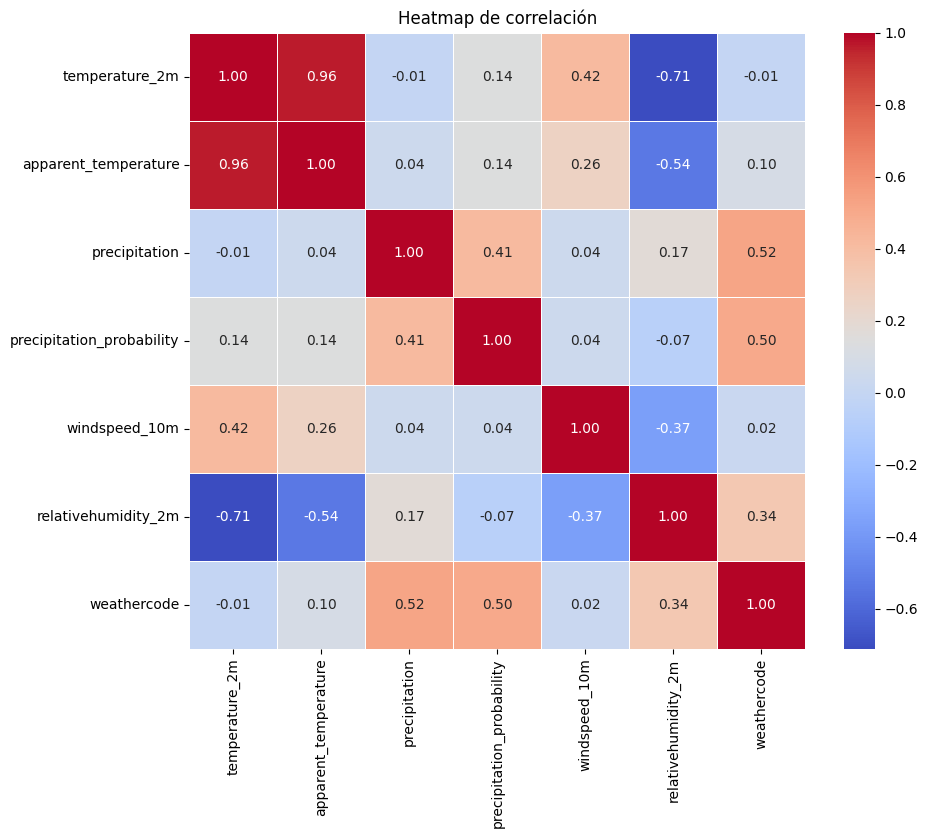

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df_clima_final["precipitation_probability"] = df_clima_final["precipitation_probability"].astype(float)
corr = df_clima_final.corr(numeric_only=True, method="pearson")

plt.figure(figsize=(10,8))

sns.heatmap(
    corr,
    annot=True,        # muestra valores
    fmt=".2f",         # 2 decimales
    cmap="coolwarm",   # paleta
    square=True,
    linewidths=.5
)

plt.title("Heatmap de correlación")
plt.show()


# Ingenieria de Variables

In [17]:
df_clima_final

,time,temperature_2m,apparent_temperature,precipitation,precipitation_probability,windspeed_10m,relativehumidity_2m,weathercode,alcaldia
0,2024-01-01T00:00,10.80000,8.10000,0.00000,NaN,5.30000,54,0,ALVARO OBREGON
1,2024-01-01T01:00,10.40000,7.80000,0.00000,NaN,5.70000,56,0,ALVARO OBREGON
2,2024-01-01T02:00,9.40000,6.80000,0.00000,NaN,5.50000,61,0,ALVARO OBREGON
3,2024-01-01T03:00,9.90000,7.40000,0.00000,NaN,4.90000,60,3,ALVARO OBREGON
4,2024-01-01T04:00,8.20000,5.60000,0.00000,NaN,5.60000,66,2,ALVARO OBREGON
...,...,...,...,...,...,...,...,...,...
301819,2026-02-22T19:00,10.90000,7.90000,0.00000,0.00000,11.30000,63,0,XOCHIMILCO
301820,2026-02-22T20:00,8.70000,6.30000,0.00000,0.00000,8.10000,78,0,XOCHIMILCO
301821,2026-02-22T21:00,6.90000,4.80000,0.00000,0.00000,5.90000,89,0,XOCHIMILCO
301822,2026-02-22T22:00,5.80000,3.80000,0.00000,0.00000,5.20000,94,0,XOCHIMILCO


In [18]:
df_clima_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301824 entries, 0 to 301823
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       301824 non-null  object 
 1   temperature_2m             301824 non-null  float64
 2   apparent_temperature       301824 non-null  float64
 3   precipitation              301824 non-null  float64
 4   precipitation_probability  2688 non-null    float64
 5   windspeed_10m              301824 non-null  float64
 6   relativehumidity_2m        301824 non-null  int64  
 7   weathercode                301824 non-null  int64  
 8   alcaldia                   301824 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 20.7+ MB


In [19]:
df = df_clima_final.copy()

df["time"] = pd.to_datetime(df["time"])

df["year"]  = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"]   = df["time"].dt.day
df["hour"]  = df["time"].dt.hour
df["dow"]   = df["time"].dt.dayofweek

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

df["dow_sin"] = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"] = np.cos(2*np.pi*df["dow"]/7)


## Sepración de Sets

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

target = "precipitation_probability"

df_train = df[df[target].notna()].copy()
df_pred  = df[df[target].isna()].copy()


In [21]:
df_train = df_train.sort_values("time")

cut = int(len(df_train)*0.8)

train_set = df_train.iloc[:cut]
valid_set = df_train.iloc[cut:]

In [22]:
num_features = [
    "temperature_2m",
    "apparent_temperature",
    "precipitation",
    "windspeed_10m",
    "relativehumidity_2m",
    "weathercode",
    "hour_sin","hour_cos",
    "month_sin","month_cos",
    "dow_sin","dow_cos"
]

cat_features = ["alcaldia"]

# Modelado

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


models = {
    "rf": RandomForestRegressor(n_estimators=300, max_depth=12),
    "gbr": GradientBoostingRegressor(n_estimators=300, max_depth=16),
    "hgb": HistGradientBoostingRegressor(),
    "mlp": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500)
}

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

results = {}

for name, model in models.items():

    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])

    pipe.fit(train_set[num_features+cat_features], train_set[target])
    preds = pipe.predict(valid_set[num_features+cat_features])

    mae = mean_absolute_error(valid_set[target], preds)
    r2  = r2_score(valid_set[target], preds)
    results[name] = (mae, r2)

results


{'rf': (5.149927931085131, -95.06372118147227),
 'gbr': (5.5421652702586695, -158.94877679833482),
 'hgb': (5.694875398196647, -69.64751266370492),
 'mlp': (15.831491551887018, -612.8262799227081)}

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

mlp = MLPRegressor(max_iter=800, early_stopping=True)

param_dist = {
    "model__hidden_layer_sizes": [
        (64,32),
        (128,64),
        (128,64,32),
        (256,128)
    ],
    "model__activation": ["relu","tanh"],
    "model__alpha": [0.0001, 0.001, 0.01],
    "model__learning_rate_init": [0.001, 0.005, 0.01],
    "model__batch_size": [64,128,256]
}

pipe = Pipeline([
    ("prep", preprocess),
    ("model", mlp)
])

tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=20,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

search.fit(
    train_set[num_features+cat_features],
    train_set[target]
)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['temperature_2m',
                                                                                'apparent_temperature',
                                                                                'precipitation',
                                                                                'windspeed_10m',
                                                                                'relativehumidity_2m',
                                                                                'weathercode',
                                                                                'hour_sin',
                                                                                'hour_cos',
                                                                                'month_sin',
                                                                                'month_cos',
                                                                                'dow_sin',
                                                                                'dow...
                                              MLPRegressor(early_stopping=True,
                                                           max_iter=800))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__activation': ['relu', 'tanh'],
                                        'model__alpha': [0.0001, 0.001, 0.01],
                                        'model__batch_size': [64, 128, 256],
                                        'model__hidden_layer_sizes': [(64, 32),
                                                                      (128, 64),
                                                                      (128, 64,
                                                                       32),
                                                                      (256,
                                                                       128)],
                                        'model__learning_rate_init': [0.001,
                                                                      0.005,
                                                                      0.01]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [27]:
search.cv_results_

{'mean_fit_time': array([0.78017346, 2.13281131, 0.54378708, 0.63060768, 1.79684695,
        2.22803473, 1.43265462, 1.29462616, 2.26756652, 0.59345524,
        0.32447767, 0.58649818, 1.00492414, 0.44418248, 0.77739636,
        3.87255589, 0.67006826, 6.44547431, 0.63366636, 0.97157065]),
 'std_fit_time': array([0.26599806, 0.84232641, 0.53184497, 0.14042383, 0.67358492,
        1.67039907, 0.68223169, 1.12791527, 0.6303739 , 0.108431  ,
        0.09066047, 0.28841189, 0.17113944, 0.13368106, 0.59356386,
        1.53940855, 0.42756519, 0.75132905, 0.152969  , 0.46339009]),
 'mean_score_time': array([0.00916235, 0.01140555, 0.015721  , 0.01009401, 0.00992759,
        0.01378616, 0.01011443, 0.016095  , 0.01730792, 0.0089337 ,
        0.00782935, 0.00795205, 0.01020304, 0.00772532, 0.00746417,
        0.01482232, 0.00975037, 0.01015409, 0.00778198, 0.01240524]),
 'std_score_time': array([8.44347975e-04, 4.87837519e-03, 2.63295611e-04, 9.18362666e-04,
        4.53423805e-04, 4.09549794e-

In [28]:
cv_df = pd.DataFrame(search.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate_init,param_model__hidden_layer_sizes,param_model__batch_size,param_model__alpha,param_model__activation,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.78017,0.26600,0.00916,0.00084,0.01000,"(64, 32)",128,0.00010,tanh,"{'model__learning_rate_init': 0.01, 'model__hi...",-6.66486,-8.56172,-8.00526,-7.74395,0.79613,10
1,2.13281,0.84233,0.01141,0.00488,0.00100,"(128, 64)",128,0.00010,relu,"{'model__learning_rate_init': 0.001, 'model__h...",-15.36882,-1.85788,-3.41554,-6.88075,6.03557,7
2,0.54379,0.53184,0.01572,0.00026,0.00500,"(64, 32)",256,0.00010,relu,"{'model__learning_rate_init': 0.005, 'model__h...",-8.50810,-1.58546,-7.44681,-5.84679,3.04421,4
3,0.63061,0.14042,0.01009,0.00092,0.00500,"(256, 128)",128,0.00100,relu,"{'model__learning_rate_init': 0.005, 'model__h...",-17.06096,-0.50887,-2.85324,-6.80769,7.31306,6
4,1.79685,0.67358,0.00993,0.00045,0.00100,"(128, 64)",64,0.00100,tanh,"{'model__learning_rate_init': 0.001, 'model__h...",-9.97349,-7.25093,-7.55151,-8.25864,1.21878,13


In [29]:
cv_df.sort_values("mean_test_score", ascending=False)[
    [
        "mean_test_score",
        "std_test_score",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "params"
    ]
].head(10)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,params
12,-5.03066,1.22029,-6.58638,-3.60593,-4.89968,"{'model__learning_rate_init': 0.01, 'model__hi..."
7,-5.03952,3.97465,-10.05031,-0.32829,-4.73995,"{'model__learning_rate_init': 0.005, 'model__h..."
14,-5.38427,4.45491,-11.22752,-0.42263,-4.50267,"{'model__learning_rate_init': 0.005, 'model__h..."
2,-5.84679,3.04421,-8.50810,-1.58546,-7.44681,"{'model__learning_rate_init': 0.005, 'model__h..."
5,-6.69522,0.72198,-6.70418,-5.80652,-7.57494,"{'model__learning_rate_init': 0.005, 'model__h..."
3,-6.80769,7.31306,-17.06096,-0.50887,-2.85324,"{'model__learning_rate_init': 0.005, 'model__h..."
1,-6.88075,6.03557,-15.36882,-1.85788,-3.41554,"{'model__learning_rate_init': 0.001, 'model__h..."
19,-6.88874,5.96580,-14.84760,-0.48473,-5.33389,"{'model__learning_rate_init': 0.005, 'model__h..."
8,-7.24548,3.71296,-12.33848,-3.59212,-5.80585,"{'model__learning_rate_init': 0.005, 'model__h..."
0,-7.74395,0.79613,-6.66486,-8.56172,-8.00526,"{'model__learning_rate_init': 0.01, 'model__hi..."


In [30]:
search.best_params_

{'model__learning_rate_init': 0.01,
 'model__hidden_layer_sizes': (128, 64, 32),
 'model__batch_size': 64,
 'model__alpha': 0.0001,
 'model__activation': 'tanh'}

In [31]:
search.best_score_

np.float64(-5.030664387656085)

In [32]:
best_pipe = search.best_estimator_

# Preservación del modelo

In [33]:
best_pipe = search.best_estimator_

best_pipe.fit(
    df_train[num_features+cat_features],
    df_train[target]
)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperature_2m',
                                                   'apparent_temperature',
                                                   'precipitation',
                                                   'windspeed_10m',
                                                   'relativehumidity_2m',
                                                   'weathercode', 'hour_sin',
                                                   'hour_cos', 'month_sin',
                                                   'month_cos', 'dow_sin',
                                                   'dow_cos']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['alcaldia'])])),
                ('model',
                 MLPRegressor(activation='tanh', batch_size=64,
                              early_stopping=True,
                              hidden_layer_sizes=(128, 64, 32),
                              learning_rate_init=0.01, max_iter=800))])

In [34]:
# pred_vals = best_pipe.predict(
#     df_pred[num_features+cat_features]
# )

# df.loc[df[target].isna(), target] = pred_vals.clip(0,100)

pred_vals = best_pipe.predict(
    df_pred[num_features+cat_features]
)

df.loc[df[target].isna(), target] = pred_vals.clip(0,100)


In [35]:
df

,time,temperature_2m,apparent_temperature,precipitation,precipitation_probability,windspeed_10m,relativehumidity_2m,weathercode,alcaldia,year,month,day,hour,dow,hour_sin,hour_cos,month_sin,month_cos,dow_sin,dow_cos
0,2024-01-01 00:00:00,10.80000,8.10000,0.00000,0.14347,5.30000,54,0,ALVARO OBREGON,2024,1,1,0,0,0.00000,1.00000,0.50000,0.86603,0.00000,1.00000
1,2024-01-01 01:00:00,10.40000,7.80000,0.00000,0.00000,5.70000,56,0,ALVARO OBREGON,2024,1,1,1,0,0.25882,0.96593,0.50000,0.86603,0.00000,1.00000
2,2024-01-01 02:00:00,9.40000,6.80000,0.00000,0.00000,5.50000,61,0,ALVARO OBREGON,2024,1,1,2,0,0.50000,0.86603,0.50000,0.86603,0.00000,1.00000
3,2024-01-01 03:00:00,9.90000,7.40000,0.00000,0.00000,4.90000,60,3,ALVARO OBREGON,2024,1,1,3,0,0.70711,0.70711,0.50000,0.86603,0.00000,1.00000
4,2024-01-01 04:00:00,8.20000,5.60000,0.00000,0.00000,5.60000,66,2,ALVARO OBREGON,2024,1,1,4,0,0.86603,0.50000,0.50000,0.86603,0.00000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301819,2026-02-22 19:00:00,10.90000,7.90000,0.00000,0.00000,11.30000,63,0,XOCHIMILCO,2026,2,22,19,6,-0.96593,0.25882,0.86603,0.50000,-0.78183,0.62349
301820,2026-02-22 20:00:00,8.70000,6.30000,0.00000,0.00000,8.10000,78,0,XOCHIMILCO,2026,2,22,20,6,-0.86603,0.50000,0.86603,0.50000,-0.78183,0.62349
301821,2026-02-22 21:00:00,6.90000,4.80000,0.00000,0.00000,5.90000,89,0,XOCHIMILCO,2026,2,22,21,6,-0.70711,0.70711,0.86603,0.50000,-0.78183,0.62349
301822,2026-02-22 22:00:00,5.80000,3.80000,0.00000,0.00000,5.20000,94,0,XOCHIMILCO,2026,2,22,22,6,-0.50000,0.86603,0.86603,0.50000,-0.78183,0.62349


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301824 entries, 0 to 301823
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       301824 non-null  datetime64[ns]
 1   temperature_2m             301824 non-null  float64       
 2   apparent_temperature       301824 non-null  float64       
 3   precipitation              301824 non-null  float64       
 4   precipitation_probability  301824 non-null  float64       
 5   windspeed_10m              301824 non-null  float64       
 6   relativehumidity_2m        301824 non-null  int64         
 7   weathercode                301824 non-null  int64         
 8   alcaldia                   301824 non-null  object        
 9   year                       301824 non-null  int32         
 10  month                      301824 non-null  int32         
 11  day                        301824 non-null  int32   

In [38]:
fecha_minima = df['time'].min()
fecha_maxima = df['time'].max()

print(f" Rango de datos:")
print(f"Desde: {fecha_minima}")
print(f"Hasta: {fecha_maxima}")
print(f"Total de días: {(fecha_maxima - fecha_minima).days} días")

 Rango de datos:
Desde: 2024-01-01 00:00:00
Hasta: 2026-02-22 23:00:00
Total de días: 783 días


In [39]:
df.columns

Index(['time', 'temperature_2m', 'apparent_temperature', 'precipitation',
       'precipitation_probability', 'windspeed_10m', 'relativehumidity_2m',
       'weathercode', 'alcaldia', 'year', 'month', 'day', 'hour', 'dow',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'],
      dtype='object')

In [40]:
df_alcaldias.columns

Index(['alcaldia', 'lat', 'lon'], dtype='object')

In [41]:
df_clima_completo=df[['time', 'temperature_2m', 'apparent_temperature', 'precipitation',
       'precipitation_probability', 'windspeed_10m', 'relativehumidity_2m',
       'weathercode', 'alcaldia']].copy()
df_clima_completo

,time,temperature_2m,apparent_temperature,precipitation,precipitation_probability,windspeed_10m,relativehumidity_2m,weathercode,alcaldia
0,2024-01-01 00:00:00,10.80000,8.10000,0.00000,0.14347,5.30000,54,0,ALVARO OBREGON
1,2024-01-01 01:00:00,10.40000,7.80000,0.00000,0.00000,5.70000,56,0,ALVARO OBREGON
2,2024-01-01 02:00:00,9.40000,6.80000,0.00000,0.00000,5.50000,61,0,ALVARO OBREGON
3,2024-01-01 03:00:00,9.90000,7.40000,0.00000,0.00000,4.90000,60,3,ALVARO OBREGON
4,2024-01-01 04:00:00,8.20000,5.60000,0.00000,0.00000,5.60000,66,2,ALVARO OBREGON
...,...,...,...,...,...,...,...,...,...
301819,2026-02-22 19:00:00,10.90000,7.90000,0.00000,0.00000,11.30000,63,0,XOCHIMILCO
301820,2026-02-22 20:00:00,8.70000,6.30000,0.00000,0.00000,8.10000,78,0,XOCHIMILCO
301821,2026-02-22 21:00:00,6.90000,4.80000,0.00000,0.00000,5.90000,89,0,XOCHIMILCO
301822,2026-02-22 22:00:00,5.80000,3.80000,0.00000,0.00000,5.20000,94,0,XOCHIMILCO


In [42]:
df_alcaldias

,alcaldia,lat,lon
0,ALVARO OBREGON,19.36100,-99.19400
1,AZCAPOTZALCO,19.48500,-99.18500
2,BENITO JUAREZ,19.38000,-99.16100
3,COYOACAN,19.34300,-99.15600
4,CUAJIMALPA,19.35500,-99.29100
5,CUAUHTEMOC,19.43200,-99.13300
6,GUSTAVO A MADERO,19.48500,-99.11000
7,IZTACALCO,19.39500,-99.09700
8,IZTAPALAPA,19.34600,-99.06200
9,MAGDALENA CONTRERAS,19.31300,-99.24100


In [43]:
import duckdb

# Digamos que quieres consultar el dataframe que acabamos de crear
query = """
SELECT A.*, B.lat, B.lon
FROM df_clima_completo AS A
LEFT JOIN df_alcaldias  AS B
ON A.alcaldia = B.alcaldia
"""

# DuckDB reconoce 'inviales_completo' automáticamente
df_clima_completo1 = duckdb.query(query).to_df()
df_clima_completo1

,time,temperature_2m,apparent_temperature,precipitation,precipitation_probability,windspeed_10m,relativehumidity_2m,weathercode,alcaldia,lat,lon
0,2024-12-02 16:00:00,23.90000,20.10000,0.00000,3.08189,3.80000,10,0,CUAUHTEMOC,19.43200,-99.13300
1,2024-12-02 17:00:00,23.50000,19.30000,0.00000,45.18740,6.60000,10,0,CUAUHTEMOC,19.43200,-99.13300
2,2024-12-02 18:00:00,19.80000,16.00000,0.00000,38.38182,14.80000,33,0,CUAUHTEMOC,19.43200,-99.13300
3,2024-12-02 19:00:00,17.60000,14.00000,0.00000,1.72840,16.10000,44,1,CUAUHTEMOC,19.43200,-99.13300
4,2024-12-02 20:00:00,16.00000,12.50000,0.00000,0.00000,14.60000,46,0,CUAUHTEMOC,19.43200,-99.13300
...,...,...,...,...,...,...,...,...,...,...,...
301819,2026-02-22 19:00:00,10.90000,7.90000,0.00000,0.00000,11.30000,63,0,XOCHIMILCO,19.26300,-99.10400
301820,2026-02-22 20:00:00,8.70000,6.30000,0.00000,0.00000,8.10000,78,0,XOCHIMILCO,19.26300,-99.10400
301821,2026-02-22 21:00:00,6.90000,4.80000,0.00000,0.00000,5.90000,89,0,XOCHIMILCO,19.26300,-99.10400
301822,2026-02-22 22:00:00,5.80000,3.80000,0.00000,0.00000,5.20000,94,0,XOCHIMILCO,19.26300,-99.10400


In [45]:
import geopandas as gpd
import pandas as pd
import os

# 1. Definir rutas
folder_path = '/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados'
file_name = 'DB_Clima.parquet'
full_path_geoparquet = os.path.join(folder_path, file_name)

# 2. Crear el GeoDataFrame correctamente
# Usamos latitud y longitud para crear la columna geometry de forma inmediata
if not isinstance(df_clima_completo1, gpd.GeoDataFrame):
    print("--- Convirtiendo a GeoDataFrame ---")
    df_clima_completo1 = gpd.GeoDataFrame(
        df_clima_completo1,
        geometry=gpd.points_from_xy(df_clima_completo1['lon'], df_clima_completo1['lat']),
        crs="EPSG:4326"
    )
else:
    df_clima_completo1 = df_clima_completo1.copy()

# 3. Guardar el objeto correcto (df_abt_final)
# Es importante guardar df_abt_final, que es el que ya tiene la geometría oficial
df_clima_completo1.to_parquet(full_path_geoparquet)

print(f" ¡Éxito! Guardado como GeoParquet en: {full_path_geoparquet}")
print(f"Registros guardados: {len(df_clima_completo1):,}")

--- Convirtiendo a GeoDataFrame ---
 ¡Éxito! Guardado como GeoParquet en: /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados/DB_Clima.parquet
Registros guardados: 301,824
